In [1]:
from rs.utils import utils
import os
from typing import List, Tuple
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"  # to avoid memory fragmentation
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import math
import numpy as np
from rs.envs.engine import SignalCoverage
import mitsuba as mi
import drjit as dr
import copy

E0000 00:00:1755285585.742074  156057 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755285585.749681  156057 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755285585.769395  156057 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755285585.769422  156057 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755285585.769424  156057 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755285585.769427  156057 computation_placer.cc:177] computation placer already registered. Please check linka

## No Reflector

In [2]:
sionna_config_file = '/home/hieule/research/saris_revised/configs/sionna_hallway_focus_ma.yaml'
xml_dir = "/home/hieule/research/saris_revised/local_assets/blender/no_reflector"

sionna_config = utils.load_config(sionna_config_file)
sionna_config["seed"] = 10
sionna_config["num_runs_before_restart"] = 10
scene_name = f"{sionna_config['scene_name']}_0"
sionna_config["scene_name"] = scene_name

viz_scene_path = os.path.join(xml_dir, "idx", "scenee.xml")
compute_scene_path = os.path.join(xml_dir, "ceiling_idx", "scenee.xml")
sionna_config["xml_dir"] = xml_dir
sionna_config["viz_scene_path"] = viz_scene_path
sionna_config["compute_scene_path"] = compute_scene_path

image_dir = "/home/hieule/research/saris_revised/local_assets/Hallway_L/no_reflector/images"
image_dir = os.path.join(image_dir, scene_name)
# image_dir = config.image_dir
sionna_config["image_dir"] = image_dir

sionna_config["rendering"] = True
sionna_config

{'base_config': 'hallway',
 'scene_name': 'hallway_L_0',
 'blender_app': '/home/hieule/blender/blender-3.3.14-linux-x64/blender',
 'blender_dir': '/home/hieule/blender/',
 'xml_dir': '/home/hieule/research/saris_revised/local_assets/blender/no_reflector',
 'blender_script': '/home/hieule/research/saris_revised/rs/bscripts/generate_scene_focus_ma.py',
 'image_dir': '/home/hieule/research/saris_revised/local_assets/Hallway_L/no_reflector/images/hallway_L_0',
 'resolution': [1920, 1080],
 'rm_vmin': -100,
 'rm_vmax': -60,
 'verbose': True,
 'cam_position': [1.3, -4.0, 50.0],
 'cam_orientation': [0.0, 0.0, 0.0],
 'cam_look_at': [1.3, -4.0, 0.0],
 'frequency': 60000000000.0,
 'synthetic_array': True,
 'rf_positions': [[11.2266, -5.75369, 1.93559],
  [11.0922, -5.88804, 2.06059],
  [10.9579, -6.02239, 1.93559]],
 'tx_power_dbm': 5.0,
 'tx_num_rows': 1,
 'tx_num_cols': 1,
 'tx_vertical_spacing': 0.5,
 'tx_horizontal_spacing': 0.5,
 'tx_pattern': 'tr38901',
 'tx_polarization': 'V',
 'tx_positi

In [3]:
sigmap = SignalCoverage(
    sionna_config=sionna_config,seed=sionna_config["seed"],)

In [4]:
rm = sigmap.compute_cmap()


In [5]:
rm_rss = rm.rss
rx_cell_indices = rm.rx_cell_indices
print(rm_rss.shape)
rssis = np.zeros((3, 3))
for rx_idx in range(rx_cell_indices.shape[1]):
    print(f"Processing receiver index: {rx_idx}")
    rssi = rm_rss[:, rx_cell_indices[1][rx_idx], rx_cell_indices[0][rx_idx]]
    rssis[:, rx_idx] = rssi

(3, 51, 107)
Processing receiver index: 0
Processing receiver index: 1
Processing receiver index: 2


In [6]:
rssis.shape

(3, 3)

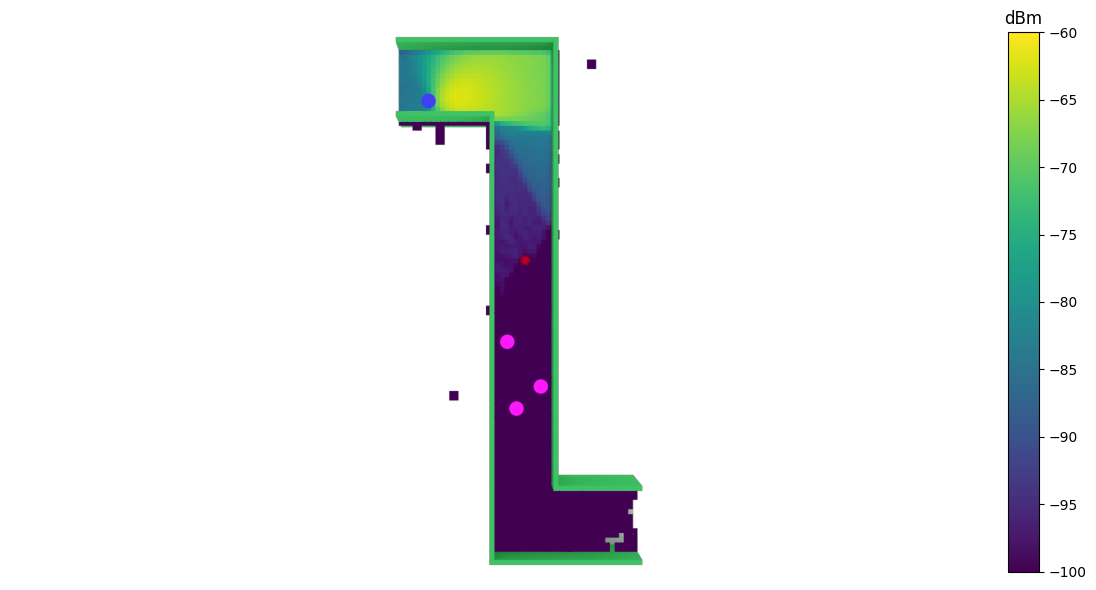

In [7]:
sigmap.render(radio_map=rm)

In [8]:
loc_idx = np.array([0, 1, 2])
rf_idx = np.arange(3)
cur_rss = rssis[..., rf_idx, loc_idx]
rfcur_rsss = 10 * np.log10(cur_rss) + 30.0
print(f"RSSI (dBm) of users: {np.round(rfcur_rsss, 2)}")
print(f"Mean RSSI (dBm): {np.mean(rfcur_rsss, axis=-1):.2f}")

RSSI (dBm) of users: [-103.31 -111.1  -110.31]
Mean RSSI (dBm): -108.24


## Flat Reflector

In [9]:
sionna_config_file = '/home/hieule/research/saris_revised/configs/sionna_hallway_focus_ma.yaml'
xml_dir = "/home/hieule/research/saris_revised/local_assets/blender/flat_reflector"

sionna_config = utils.load_config(sionna_config_file)
sionna_config["seed"] = 10
sionna_config["num_runs_before_restart"] = 10
scene_name = f"{sionna_config['scene_name']}_0"
sionna_config["scene_name"] = scene_name

viz_scene_path = os.path.join(xml_dir, "idx", "scenee.xml")
compute_scene_path = os.path.join(xml_dir, "ceiling_idx", "scenee.xml")
sionna_config["xml_dir"] = xml_dir
sionna_config["viz_scene_path"] = viz_scene_path
sionna_config["compute_scene_path"] = compute_scene_path

image_dir = "/home/hieule/research/saris_revised/local_assets/Hallway_L/flat_reflector/images"
image_dir = os.path.join(image_dir, scene_name)
# image_dir = config.image_dir
sionna_config["image_dir"] = image_dir

sionna_config["rendering"] = True
sionna_config

{'base_config': 'hallway',
 'scene_name': 'hallway_L_0',
 'blender_app': '/home/hieule/blender/blender-3.3.14-linux-x64/blender',
 'blender_dir': '/home/hieule/blender/',
 'xml_dir': '/home/hieule/research/saris_revised/local_assets/blender/flat_reflector',
 'blender_script': '/home/hieule/research/saris_revised/rs/bscripts/generate_scene_focus_ma.py',
 'image_dir': '/home/hieule/research/saris_revised/local_assets/Hallway_L/flat_reflector/images/hallway_L_0',
 'resolution': [1920, 1080],
 'rm_vmin': -100,
 'rm_vmax': -60,
 'verbose': True,
 'cam_position': [1.3, -4.0, 50.0],
 'cam_orientation': [0.0, 0.0, 0.0],
 'cam_look_at': [1.3, -4.0, 0.0],
 'frequency': 60000000000.0,
 'synthetic_array': True,
 'rf_positions': [[11.2266, -5.75369, 1.93559],
  [11.0922, -5.88804, 2.06059],
  [10.9579, -6.02239, 1.93559]],
 'tx_power_dbm': 5.0,
 'tx_num_rows': 1,
 'tx_num_cols': 1,
 'tx_vertical_spacing': 0.5,
 'tx_horizontal_spacing': 0.5,
 'tx_pattern': 'tr38901',
 'tx_polarization': 'V',
 'tx_po

In [10]:
sigmap = SignalCoverage(
    sionna_config=sionna_config,seed=sionna_config["seed"],)

In [11]:
rm = sigmap.compute_cmap()


In [12]:
rm_rss = rm.rss
rx_cell_indices = rm.rx_cell_indices
print(rm_rss.shape)
rssis = np.zeros((3, 3))
for rx_idx in range(rx_cell_indices.shape[1]):
    print(f"Processing receiver index: {rx_idx}")
    rssi = rm_rss[:, rx_cell_indices[1][rx_idx], rx_cell_indices[0][rx_idx]]
    rssis[:, rx_idx] = rssi

(3, 51, 107)
Processing receiver index: 0
Processing receiver index: 1
Processing receiver index: 2


In [13]:
rssis.shape

(3, 3)

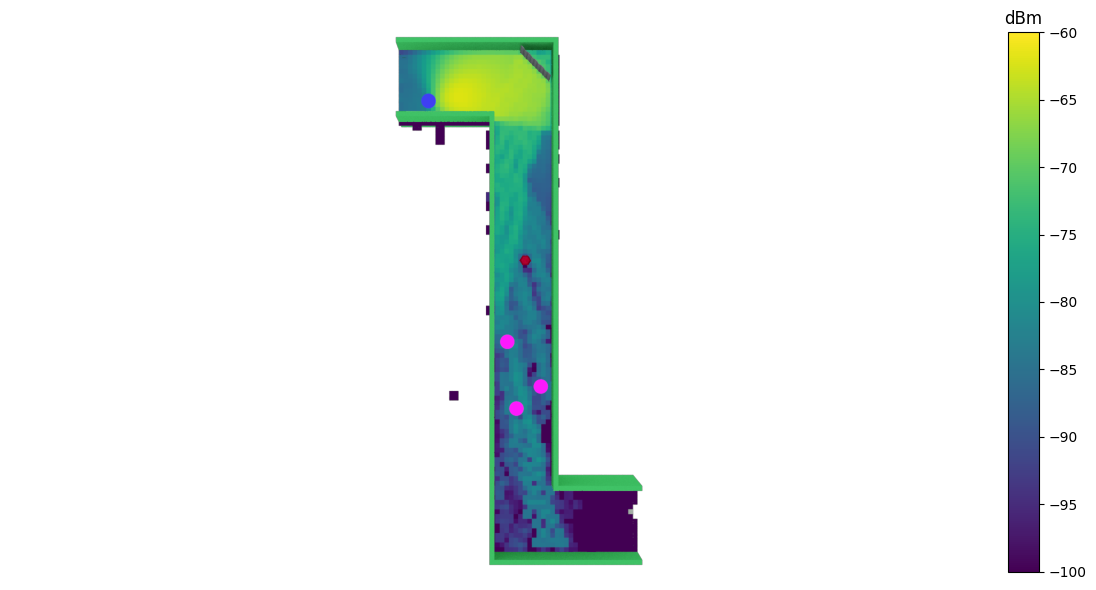

In [14]:
sigmap.render(radio_map=rm)

In [15]:
loc_idx = np.array([0, 1, 2])
rf_idx = np.arange(3)
cur_rss = rssis[..., rf_idx, loc_idx]
rfcur_rsss = 10 * np.log10(cur_rss) + 30.0
print(f"RSSI (dBm) of users: {np.round(rfcur_rsss, 2)}")
print(f"Mean RSSI (dBm): {np.mean(rfcur_rsss, axis=-1):.2f}")

RSSI (dBm) of users: [-103.27  -86.18  -80.97]
Mean RSSI (dBm): -90.14


## Outdoor

In [4]:
sionna_config_file = '/home/hieule/research/saris_revised/configs/sionna_outdoor_focus_ma.yaml'
xml_dir = "/home/hieule/research/saris_revised/local_assets/blender/outdoor/"

sionna_config = utils.load_config(sionna_config_file)
sionna_config["seed"] = 10
sionna_config["num_runs_before_restart"] = 10
scene_name = f"{sionna_config['scene_name']}_0"
sionna_config["scene_name"] = scene_name

viz_scene_path = os.path.join(xml_dir, "ceiling_idx", "scenee.xml")
compute_scene_path = os.path.join(xml_dir, "ceiling_idx", "scenee.xml")
sionna_config["xml_dir"] = xml_dir
sionna_config["viz_scene_path"] = viz_scene_path
sionna_config["compute_scene_path"] = compute_scene_path

image_dir = "/home/hieule/research/saris_revised/local_assets/outdoor/images"
image_dir = os.path.join(image_dir, scene_name)
# image_dir = config.image_dir
sionna_config["image_dir"] = image_dir

sionna_config["rendering"] = True

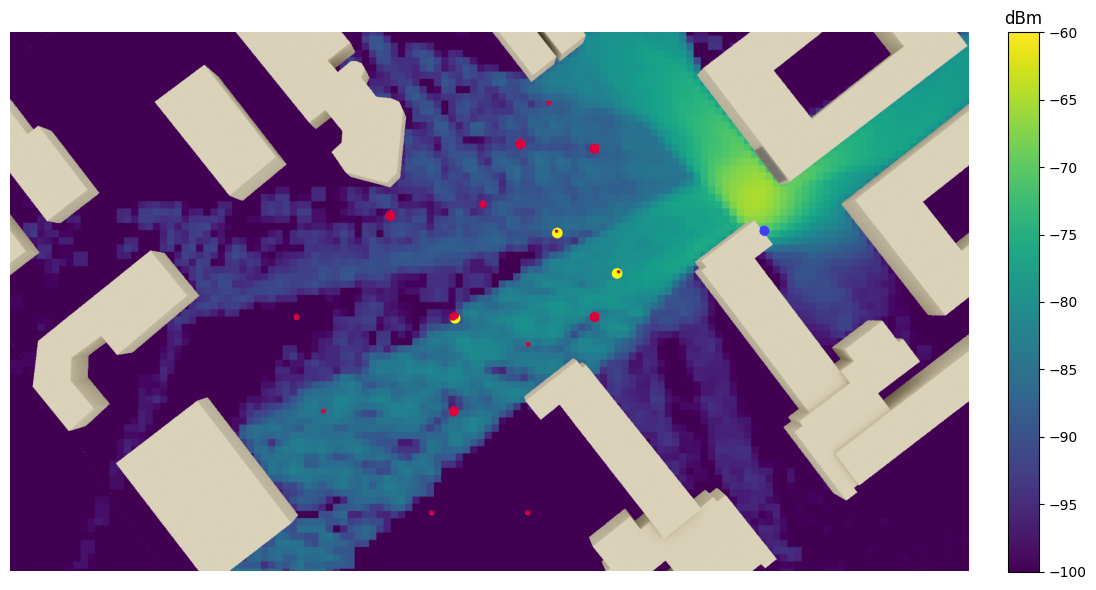

In [5]:
sigmap = SignalCoverage(
    sionna_config=sionna_config,seed=sionna_config["seed"],)
rm = sigmap.compute_cmap()
rm._pathgain_map = dr.clip(rm._pathgain_map, 1e-20, 5)
sigmap.render(radio_map=rm)

In [22]:
rm = sigmap.compute_cmap()


In [6]:
rm_rss = rm.rss
rx_cell_indices = rm.rx_cell_indices
print(rm_rss.shape)
rssis = np.zeros((3, 3))
for rx_idx in range(rx_cell_indices.shape[1]):
    print(f"Processing receiver index: {rx_idx}")
    rssi = rm_rss[:, rx_cell_indices[1][rx_idx], rx_cell_indices[0][rx_idx]]
    rssis[:, rx_idx] = rssi

(3, 183, 185)
Processing receiver index: 0
Processing receiver index: 1
Processing receiver index: 2


In [10]:
rssis.shape

(3, 3)

In [7]:
rssis = 10 * np.log10(rssis) + 30.0
print(f"RSSI (dBm) of users: {np.round(rssis, 2)}")
print(f"Mean RSSI (dBm): {np.round(np.mean(rssis, axis=-1), 2)}")

RSSI (dBm) of users: [[-81.93 -92.54 -93.92]
 [-82.87 -96.03 -94.92]
 [-82.82 -95.93 -94.83]]
Mean RSSI (dBm): [-89.46 -91.28 -91.19]


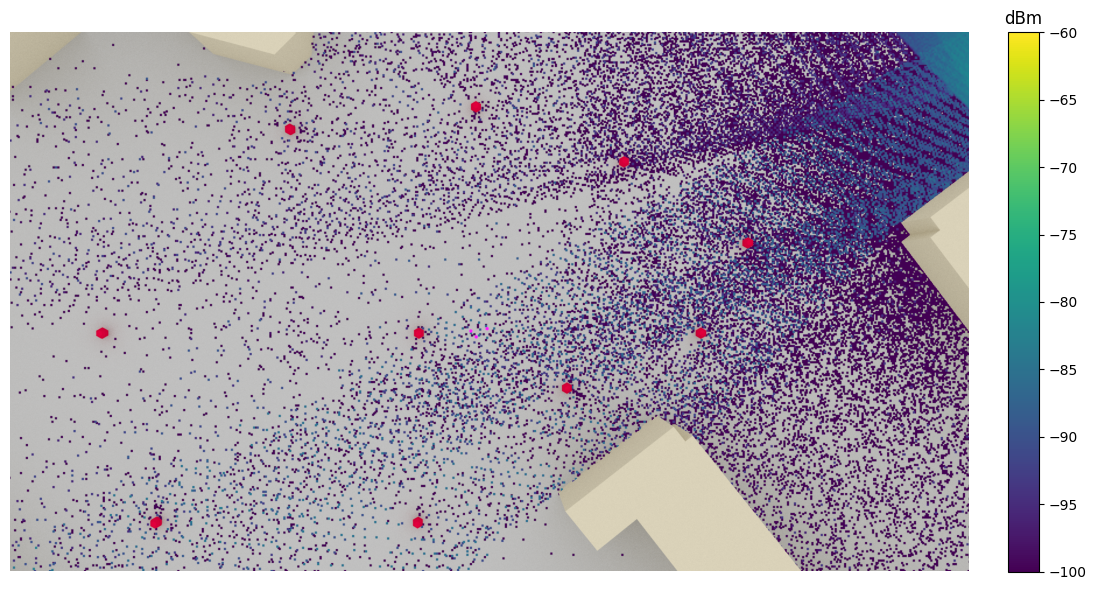

In [25]:
sigmap.render(radio_map=rm)

In [ ]:
loc_idx = np.array([0, 1, 2])
rf_idx = np.arange(3)
cur_rss = rssis[..., rf_idx, loc_idx]
rfcur_rsss = 10 * np.log10(cur_rss) + 30.0
print(f"RSSI (dBm) of users: {np.round(rfcur_rsss, 2)}")
print(f"Mean RSSI (dBm): {np.mean(rfcur_rsss, axis=-1):.2f}")

RSSI (dBm) of users: [-103.27  -86.18  -80.97]
Mean RSSI (dBm): -90.14
